In [2]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop, loss_infer
from data_load import *

## Model Definition and training

In [2]:
net = GraphVAE(3, 32, 8)

In [3]:
train_loop(net, 1, 200)

tensor(10896.8896, grad_fn=<AddBackward0>)
tensor(2671.9678, grad_fn=<AddBackward0>)
tensor(1107.5021, grad_fn=<AddBackward0>)
tensor(5418.1416, grad_fn=<AddBackward0>)
tensor(442.8770, grad_fn=<AddBackward0>)
tensor(268.6129, grad_fn=<AddBackward0>)
tensor(1596.9285, grad_fn=<AddBackward0>)
tensor(2340.0715, grad_fn=<AddBackward0>)
tensor(581.6447, grad_fn=<AddBackward0>)
tensor(328.2187, grad_fn=<AddBackward0>)
tensor(253.4985, grad_fn=<AddBackward0>)
tensor(100.8594, grad_fn=<AddBackward0>)
tensor(220.5975, grad_fn=<AddBackward0>)
tensor(237.7162, grad_fn=<AddBackward0>)
tensor(219.6064, grad_fn=<AddBackward0>)
tensor(514.3588, grad_fn=<AddBackward0>)
tensor(128.2311, grad_fn=<AddBackward0>)
tensor(38.1803, grad_fn=<AddBackward0>)
tensor(64.4990, grad_fn=<AddBackward0>)
tensor(246.7924, grad_fn=<AddBackward0>)
tensor(1756.4315, grad_fn=<AddBackward0>)
tensor(22.4341, grad_fn=<AddBackward0>)
tensor(28.8205, grad_fn=<AddBackward0>)
tensor(30.7324, grad_fn=<AddBackward0>)
tensor(25.294

In [4]:
torch.save(net.state_dict(), "Saves/L_50k_2.pth")

## Inference and tests

In [5]:
from data_load import get_train_dataset

In [6]:
net = GraphVAE(3, 32, 8)
net.load_state_dict(torch.load("Saves/L_50k_2.pth"))

<All keys matched successfully>

In [7]:
dataset = get_train_dataset(10_000)
dataloader = torch.utils.data.DataLoader(dataset, 200, True)

In [8]:
for (x,) in dataloader:
    img1 = x[:, :, :, 1]
    with torch.no_grad():
        L, img2, counts = loss_infer(net, x)
    break

In [13]:
img2[1].min()

tensor(0.)

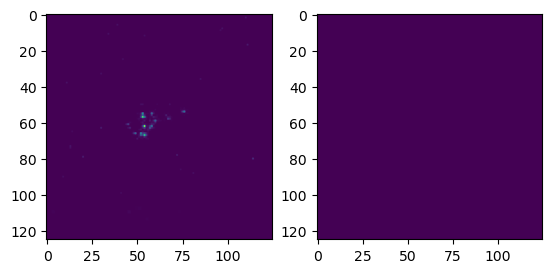

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[1]*(256/5))
ax[1].imshow(img2[1]*(256/5))
plt.show()

## Scratchpad

In [4]:
? torch.argsort

Docstring:
argsort(input, dim=-1, descending=False, stable=False) -> Tensor

Returns the indices that sort a tensor along a given dimension in ascending
order by value.

This is the second value returned by :meth:`torch.sort`.  See its documentation
for the exact semantics of this method.

If :attr:`stable` is ``True`` then the sorting routine becomes stable, preserving
the order of equivalent elements. If ``False``, the relative order of values
which compare equal is not guaranteed. ``True`` is slower.

Args:
    input (Tensor): the input tensor.
    dim (int, optional): the dimension to sort along
    descending (bool, optional): controls the sorting order (ascending or descending)
    stable (bool, optional): controls the relative order of equivalent elements

Example::

    >>> a = torch.randn(4, 4)
    >>> a
    tensor([[ 0.0785,  1.5267, -0.8521,  0.4065],
            [ 0.1598,  0.0788, -0.0745, -1.2700],
            [ 1.2208,  1.0722, -0.7064,  1.2564],
            [ 0.0669, -0.

In [16]:
x = torch.randn(100, 50, 3)
indx = torch.argsort(x[:, :, 2], descending=True)

In [17]:
batch, nodes = x.shape[0], x.shape[1]

# Change to 1d
kappa = nodes*torch.arange(batch).unsqueeze(1)
indx2 = torch.flatten(kappa + indx)
x2 = torch.flatten(x, 0, 1)[indx2, :].reshape((batch, nodes, 3))

In [28]:
A = torch.rand(100, 50, 50)

# Get indices to sort dim=1,2 of A
indx3 = ((kappa+indx)*torch.arange(nodes)).unsqueeze(2)
indx3 = indx3 + indx.unsqueeze(1)
# Flatten A, sort, and get it back to shape
A = torch.flatten(A)[indx3].reshape(A.shape)

In [29]:
A.shape

torch.Size([100, 50, 50])

In [8]:
X, mask = to_dense_batch(G, lengs, fill_value=0, max_num_nodes=1000)
A = to_dense_adj(E, lengs, max_num_nodes=1000) # (batch, 1000, 1000)


In [9]:
X = X
A = A
X.shape, A.shape

(torch.Size([2, 1000, 3]), torch.Size([2, 1000, 1000]))

In [12]:
net = GraphVAE(3, 16, 3)
net

GraphVAE(
  (sage): ModuleList(
    (0): DenseSAGEConv(3, 16)
    (1): DenseSAGEConv(16, 16)
    (2): DenseSAGEConv(16, 3)
  )
  (drop): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.4, inplace=False)
    (2): Dropout(p=0.3, inplace=False)
  )
  (batch_norm): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): ModuleList(
    (0): MinCut_Pool(
      (linear): Linear(in_features=16, out_features=500, bias=True)
    )
    (1): MinCut_Pool(
      (linear): Linear(in_features=16, out_features=250, bias=True)
    )
  )
  (tr_mu): Linear(in_features=3, out_features=16, bias=True)
  (tr_var): Linear(in_features=3, out_features=16, bias=True)
  (tr_rev): Linear(in_features=16, out_features=3, bias=True)
  (revsage): ModuleList(

In [42]:
Z, A, mu, logvar, L1, L2 = net(X, A)

In [43]:
Z.shape, A.shape

(torch.Size([2, 1000, 3]), torch.Size([2, 1000, 1000]))